In [14]:
import cPickle as pickle
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import itertools
import matplotlib.cm as cm
from collections import Counter
from sklearn.ensemble import RandomForestRegressor
from make_plots import top5plot

In [6]:
dff = pickle.load(open('pickle_pile/dff.pkl'))
dfg = pickle.load(open('pickle_pile/dfg.pkl'))

In [9]:
elg = chan_filter(dfg, 'eleaguetv')
print elg["AVG CCV's"].mean()
lirg = chan_filter(dfg, 'lirik')
d = pd.to_datetime('2016-5-24')

print lirg.query('date > @d')["AVG CCV's"].mean()

42860.6756757
25276.6190476


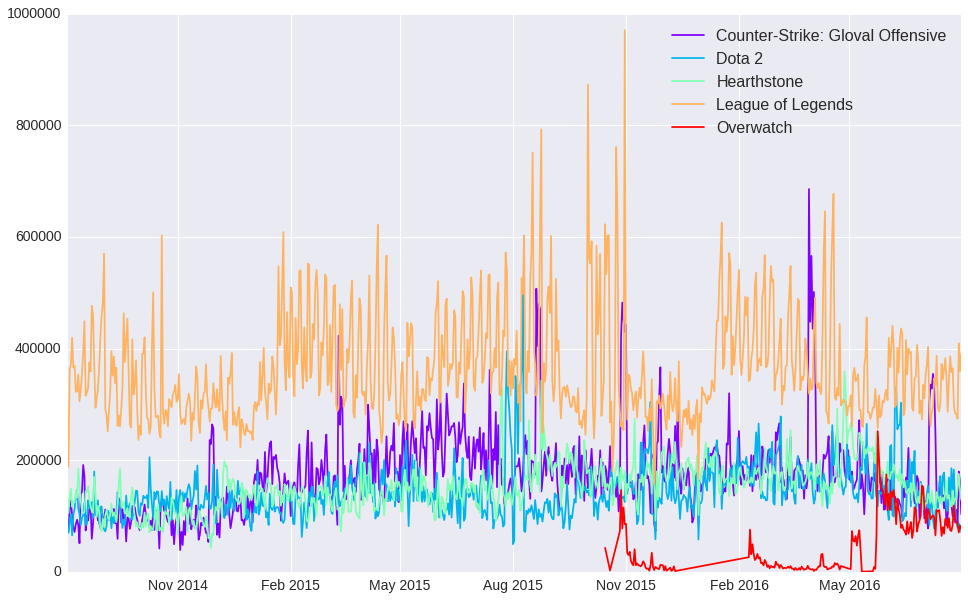

In [13]:
top5plot(dfg,ls=16)

In [8]:
# def plot_gameHW(df, game_input, logy=False):
#     gamemask = df['Main Game'].str.contains(game_input, case=False)
#     agdf = df[gamemask].groupby(['date', 'Main Game'])['Hours Watched'].sum().reset_index()
#     agdf.set_index('date', inplace=True)
#     agdf.sort_index(inplace=True)
#     colors = iter(cm.rainbow(np.linspace(0,1, len(df['Main Game'].unique()))))
#     plt.figure(figsize=(16,10))
#     for game in df['Main Game'].unique():
#         dft = game_filter(agdf, game)
#         plt.plot(dft["Hours Watched"], label=game, color=next(colors))
# #         dft.plot(x='date', y='Hours Watched', logy=logy, marker='o', color=next(colors)
#     plt.title('Hours watched for '+game)
def plot_gameHW(df, game, logy=False):
    gamemask = df['Main Game'].str.contains(game, case=False)
    agdf = df[gamemask].groupby('date')['Hours Watched'].sum().reset_index()
    agdf.plot(x='date', y='Hours Watched', logy=logy, marker='o', figsize=(16,10))
    plt.title('Hours watched for '+game)
    
def test_stationarity(timeseries):
    rolmean = pd.rolling_mean(timeseries, window = 7)
    rolstd = pd.rolling_std(timeseries, window=7)
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label='Rolling std')
    plt.legend(loc='best')
    
def plot_gamesAVG(df):#specific usage below
    colors = iter(cm.rainbow(np.linspace(0,1, len(df['Main Game'].unique()))))
    plt.figure(figsize=(16,10))
    for game in df['Main Game'].unique():
        dft = game_filter(df, game)
        plt.plot(dft["AVG CCV's"], label=game, color = next(colors))
    plt.legend(loc='best')
 
    
def game_plotc(df):

    colors = iter(cm.rainbow(np.linspace(0,1, len(df['Main Game'].unique()))))
    plt.figure(figsize=(16,10))
    for game in df['Main Game'].unique():
        game_mask = df['Main Game'].str.contains(game)
        tst = df[game_mask].copy()
        plt.plot_date(x=tst['date'] ,y=tst["AVG CCV's"],label=game, color = next(colors)) 
    df.set_index('date', inplace=True)
    rolmean = pd.Series.rolling(df["AVG CCV's"], window=7).mean()
    rolstd = pd.Series.rolling(df["AVG CCV's"], window=7).std()
    plt.plot(rolmean, color='red', label='Rolling mean')
    plt.plot(rolstd, color = 'black', label='Rolling std')
    plt.legend(loc='best')

def game_lpc(df, leg_size=None):

    colors = iter(cm.rainbow(np.linspace(0,1, len(df['Main Game'].unique()))))
    plt.figure(figsize=(16,10))
    for game in df['Main Game'].unique():
        game_mask = df['Main Game'].str.contains(game)
        tst = df[game_mask].copy()
        plt.plot_date(x=tst['date'] ,y=tst["AVG CCV's"],label=game, color = next(colors)) 
#                     color=next(colors), label=game)
    df.set_index('date', inplace=True)
    rolmean = pd.Series.rolling(df["AVG CCV's"], window=7).mean()
    rolstd = pd.Series.rolling(df["AVG CCV's"], window=7).std()
#     rolmean = pd.Series
    plt.plot(rolmean, color='red', label='Rolling mean')
    plt.plot(rolstd, color = 'black', label='Rolling std')
    plt.legend(loc='best', prop={'size':leg_size}, bbox_to_anchor=(0, 1))

def df_filter(topn,df):
    #returns data frame with only channels who average in topn of daily streams
    dfrn = df.groupby('Channel')['#'].mean().reset_index()
    dfrn = dfrn[dfrn['#']<=topn]
    topnlist = dfrn['Channel'].values
    frames = []
    for s in topnlist:
        dft = df[df['Channel']==s]
        frames.append(dft)
    dfout = pd.concat(frames, ignore_index = True)
    return dfout

def nstreams_filter(min_num, df):
    tag = df.groupby('Channel')['#'].count().reset_index()
    tag = tag[tag['#']>= min_num]
    hivol = tag['Channel'].values
    frames = []
    for s in hivol:
        dft = df[df['Channel']==s]
        frames.append(dft)
    dfout = pd.concat(frames, ignore_index=True)
    return dfout

def monsterlf_filter(cfreq, df, min_viewer=0):
    tag = df.groupby('Channel')[['avg_frequency', "AVG CCV's"]].mean().reset_index()
    tag = tag[(tag['avg_frequency'] > cfreq) & (tag["AVG CCV's"] >= min_viewer)]
    bigns = tag['Channel'].values
    frames = []
    for s in bigns:
        dft = df[df['Channel']==s]
        frames.append(dft)
    dfout = pd.concat(frames, ignore_index=True)
    return dfout

def add_ngames_col(df):
    tag = df.groupby('Channel')['Main Game'].unique().reset_index()
    tag['num_games'] = (tag['Main Game']).apply(len)
#     tag = tag[tag['num_games']>=num_games]
    chars = tag['Channel'].values
    tag.set_index('Channel', inplace=True)
    frames = []
    for pers in chars:
        dft = df[df['Channel']==pers]
        dft['num_games'] = tag.loc[pers]['num_games']
        frames.append(dft)
    dfout = pd.concat(frames, ignore_index=True)
    return dfout

def chan_filter(df,channel):
    chan_mask = df['Channel'].str.contains(channel, case=False)
    cdf = df[chan_mask]
#     cdf.set_index('date', inplace=True)
    return cdf

def game_filter(df, game):
    game_mask = df['Main Game'].str.contains(game, case=False)
    gdf = df[game_mask]
    return gdf

In [257]:
dff['date'].max()

Timestamp('2016-07-18 00:00:00')

In [252]:
# plot_gameHW(dff, 'smash bros')

In [253]:
# plot_gameHW(dff, 'league of legends')

In [254]:
# plot_channelAVG(dff, 'gamesdonequick')

In [255]:
# plot_channelAVG(dff, 'eleaguetv')

In [1]:
dff.index

NameError: name 'dff' is not defined

In [7]:
dfMlf = monsterlf_filter(8, dff, 15000)
dfhv = nstreams_filter(600,dff)
dfng = add_ngames_col(dfhv)
dfng.set_index('date', inplace=True)
dfng['dayofweek'] = dfng.index.dayofweek
dfng['weekofyear'] = dfng.index.weekofyear
dfng.reset_index(inplace=True)
# dfng[dfng['num_games'] >= 50].groupby('Channel').mean()

#good cases that don't fall into either:
# eleaguetv, gosugamers, otheroverwatch tourney streams. 
# because they are recent


/home/derek/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [35]:
# dfMlf.groupby('Main Game').sort_values("AVG CCV's", inplace=True, ascending=False)
# dfMlf[dfMlf['Main Game'].str.contains('smash', case=False)]


In [132]:
# glist = ['League of Legends', 'Dota', 'Counter-Strike : Global Offensive', 'Hearthstone', 'Overwatch']
# glhf = '|'.join(glist)
# gdf = game_filter(dfMlf, glhf)
# gav = gdf.groupby(['date','Main Game']).sum().reset_index()
# gav.set_index('date', inplace=True)
# gav.sort_index(inplace=True)


In [148]:
hdf = game_filter(dff, 'Hearthstone').copy()
csdf = game_filter(dff, 'Counter-strike').copy()
dotadf = game_filter(dff, 'dota').copy()
loldf = game_filter(dff, 'league of legends').copy()
owdf = game_filter(dff, 'overwatch').copy()
hdf['Main Game'] = 'Hearthstone'
dotadf['Main Game'] = 'Dota 2'
loldf['Main Game'] = 'League of Legends'
owdf['Main Game'] = 'Overwatch'
csdf['Main Game'] = 'Counter-Strike: Gloval Offensive'
# csgodf = game_filter(dff, 'Counter-Strike')
# csgodf = game_filter(dff, 'Counter-Strike : Global Offensive')
fdf = pd.concat([hdf, dodf, loldf, owdf, csdf])

3045.70196146


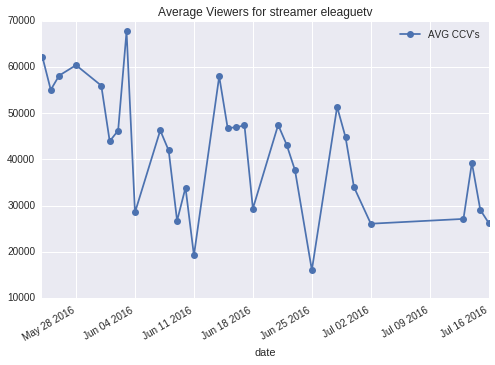

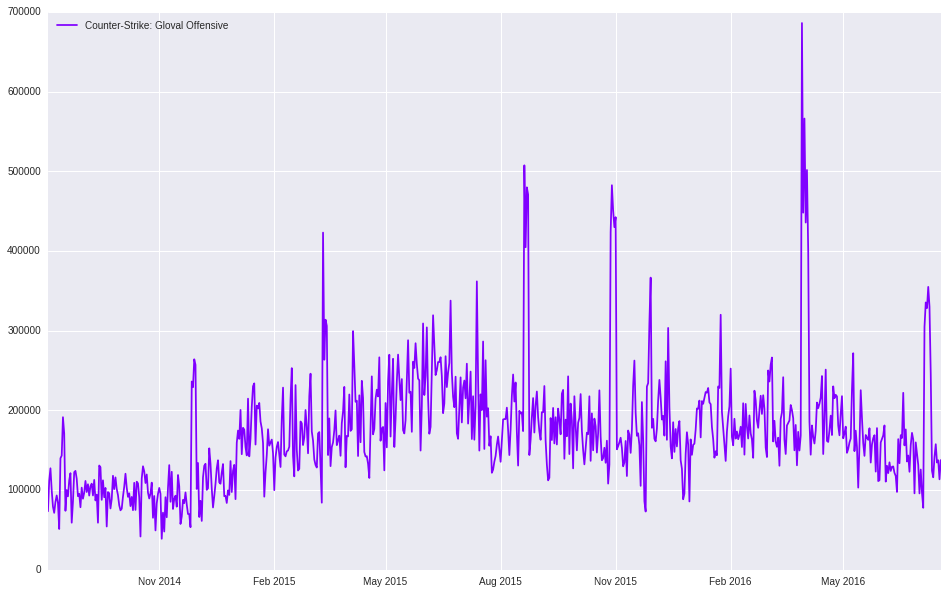

In [218]:
cs = game_filter(fdf,'Counter-strike')
print cs["AVG CCV's"].mean()
csav = cs.groupby(['date','Main Game']).sum().reset_index()
csav.set_index('date', inplace=True)
csav.sort_index(inplace=True)
# plot_channelAVG(dff, 'eleaguetv')
plot_gamesAVG(csav)

In [223]:
t = cs.set_index('date')
# t = t[:300]
t = t[['Channel', 'Language', "AVG CCV's"]]
t.sort_values("AVG CCV's", inplace=True, ascending=False)
# t.head(20)

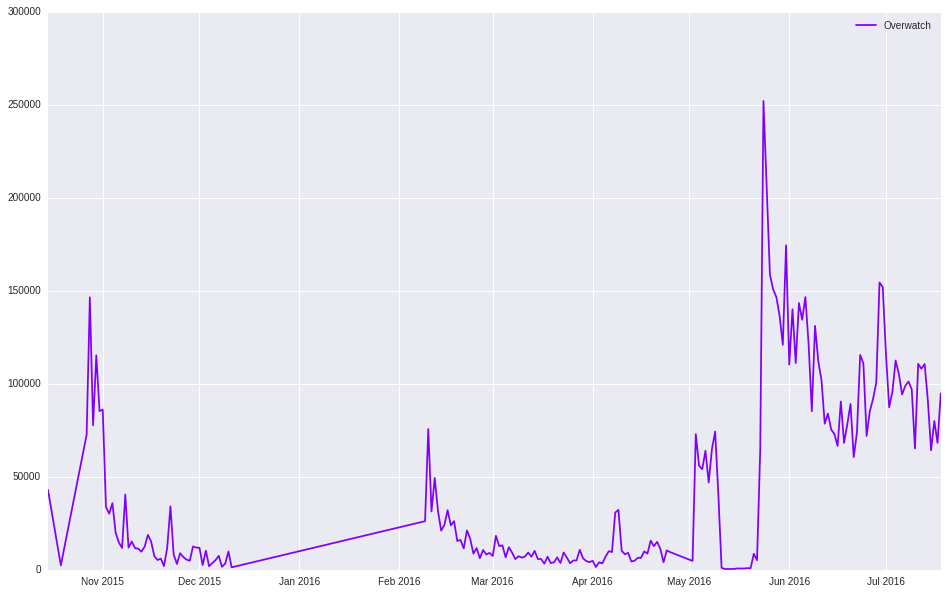

In [232]:
owv = owdf.groupby(['date', 'Main Game']).sum().reset_index()
owv.set_index('date', inplace=True)
owv.sort_index(inplace=True)
plot_gamesAVG(owv)

In [150]:
gav = fdf.groupby(['date','Main Game']).sum().reset_index()
gav.set_index('date', inplace=True)
gav.sort_index(inplace=True)

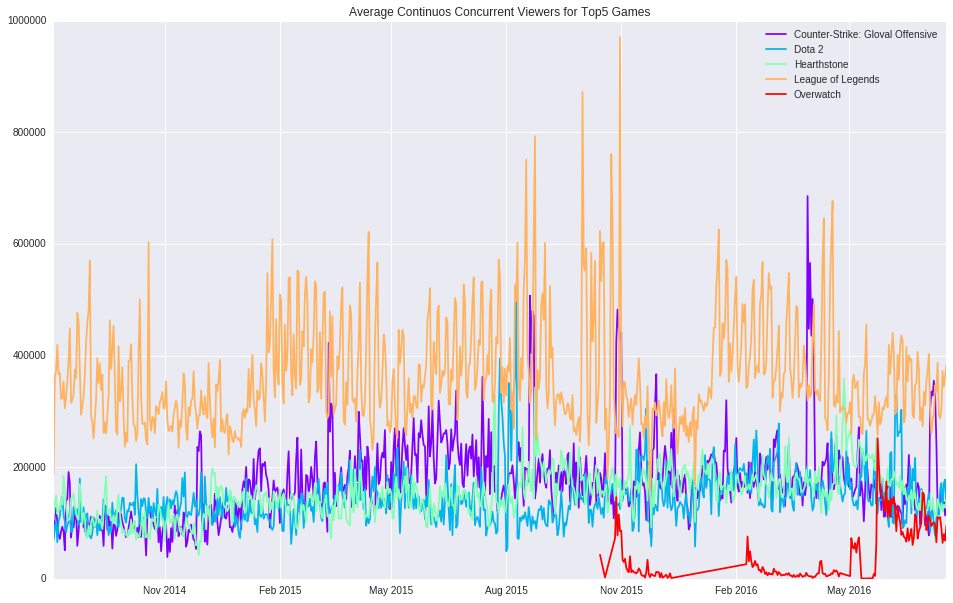

In [151]:
plot_gamesAVG(gav)
plt.title('Average Continuos Concurrent Viewers for Top5 Games')

In [159]:
# csgodf = game_filter(fdf, 'Counter-strike')
# csgodf[csgodf["AVG CCV's"]==csgodf["AVG CCV's"].max()]
# css = csgodf.sort_values("AVG CCV's", ascending=False)
# css.head(10)

In [160]:
# def plot_gamesAVG(df):
#     colors = iter(cm.rainbow(np.linspace(0,1, len(df['Main Game'].unique()))))
#     plt.figure(figsize=(16,10))
#     for game in df['Main Game'].unique():
#         dft = game_filter(df, game)
#         plt.plot(dft["AVG CCV's"], label=game, color = next(colors))
#     plt.legend(loc='best')
    
    
def game_plotc(df):

    colors = iter(cm.rainbow(np.linspace(0,1, len(df['Main Game'].unique()))))
    plt.figure(figsize=(16,10))
    for game in df['Main Game'].unique():
        game_mask = df['Main Game'].str.contains(game)
        tst = df[game_mask].copy()
        plt.plot_date(x=tst['date'] ,y=tst["AVG CCV's"],label=game, color = next(colors)) 
#                     color=next(colors), label=game)
    df.set_index('date', inplace=True)
    rolmean = pd.Series.rolling(df["AVG CCV's"], window=7).mean()
    rolstd = pd.Series.rolling(df["AVG CCV's"], window=7).std()
#     rolmean = pd.Series
    plt.plot(rolmean, color='red', label='Rolling mean')
    plt.plot(rolstd, color = 'black', label='Rolling std')
    plt.legend(loc='best')


In [10]:
# bigs = dff.query('avg_frequency > 8 & ')

In [161]:
def game_plot(df):
#     df.set_index('date', inplace=True)
#     rolmean = pd.rolling_mean(df["AVG CCV's"], window=7)
    colors = itertools.cycle(['g','b','m','c','r'])
    plt.figure(figsize=(16,10))
    for game in df['Main Game'].unique():
        game_mask = df['Main Game'].str.contains(game)
        tst = df[game_mask].copy()
        plt.plot_date(x=tst['date'] ,y=tst["AVG CCV's"],label=game) 
#                     color=next(colors), label=game)
    plt.legend(loc='best')
#     plt.show(block=False)
def game_plotc(df):

    colors = iter(cm.rainbow(np.linspace(0,1, len(df['Main Game'].unique()))))
    plt.figure(figsize=(16,10))
    for game in df['Main Game'].unique():
        game_mask = df['Main Game'].str.contains(game, case=False)
        tst = df[game_mask].copy()
        plt.plot_date(x=tst['date'] ,y=tst["AVG CCV's"],label=game, color = next(colors)) 
#                     color=next(colors), label=game)
    df.set_index('date', inplace=True)
    rolmean = pd.Series.rolling(df["AVG CCV's"], window=7).mean()
    rolstd = pd.Series.rolling(df["AVG CCV's"], window=7).std()
#     rolmean = pd.Series
    plt.plot(rolmean, color='red', label='Rolling mean')
    plt.plot(rolstd, color = 'black', label='Rolling std')
    plt.legend(loc='best')


ERROR! Session/line number was not unique in database. History logging moved to new session 315


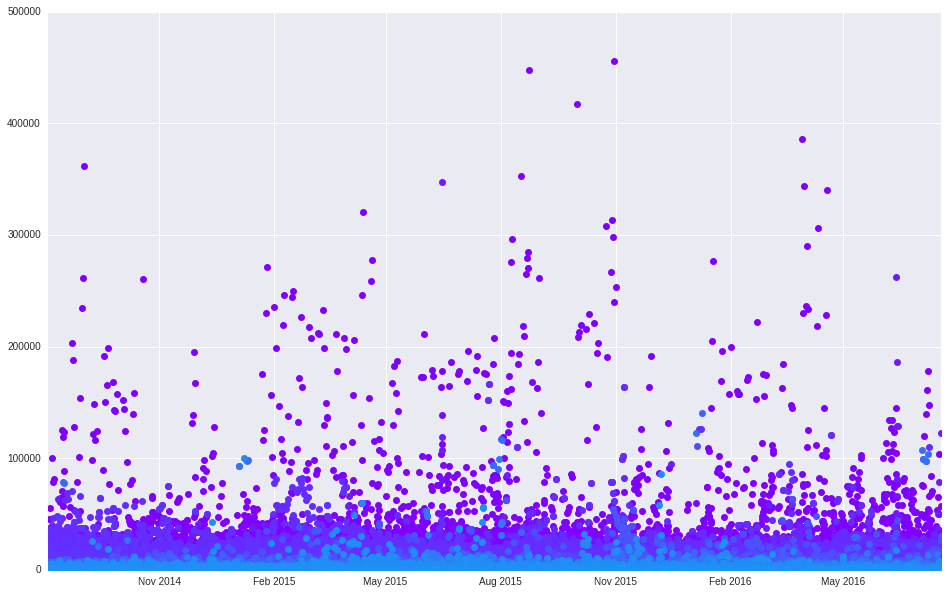

In [210]:
# game_plotc(dff)

In [8]:
dfhv['Channel'].unique()

array([u'aces_tv', u'admiral_bahroo', u'cobaltstreak', u'cohhcarnage',
       u'cowsep', u'dansgaming', u'destiny', u'hearthstonefr', u'imaqtpie',
       u'kinggothalion', u'lirik', u'mkrr3', u'mushisgosu', u'nick_28t',
       u'nightblue3', u'nl_kripp', u'ogaminglol', u'ogamingsc2',
       u'professorbroman', u'resttpowered', u'saltybet', u'seriousgaming',
       u'sodapoppin', u'streamerhouse', u'summit1g', u'towelliee',
       u'trick2g', u'tsm_theoddone', u'twitchplayspokemon', u'wingsofdeath'], dtype=object)

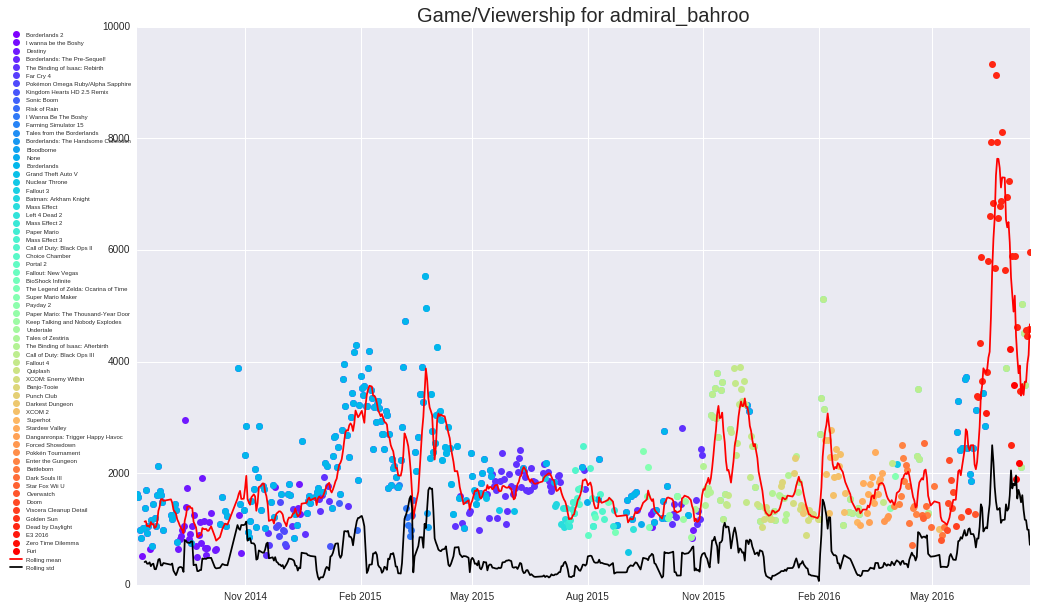

In [216]:


game_lpc(chan_filter(dfng,'admiral_bahroo'), 6)
plt.title('Game/Viewership for admiral_bahroo', fontsize=20)

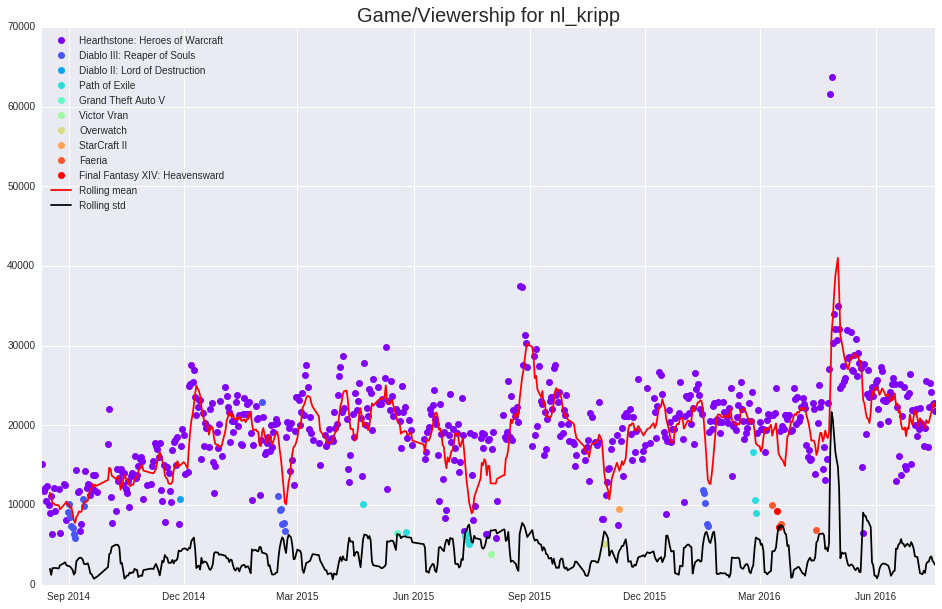

In [211]:
game_plotc(chan_filter(dfhv, 'nl_kripp'))
plt.title('Game/Viewership for nl_kripp', fontsize=20)
# test_stationarity(chan_filter(dfng, 'nl_kripp')["AVG CCV's"])

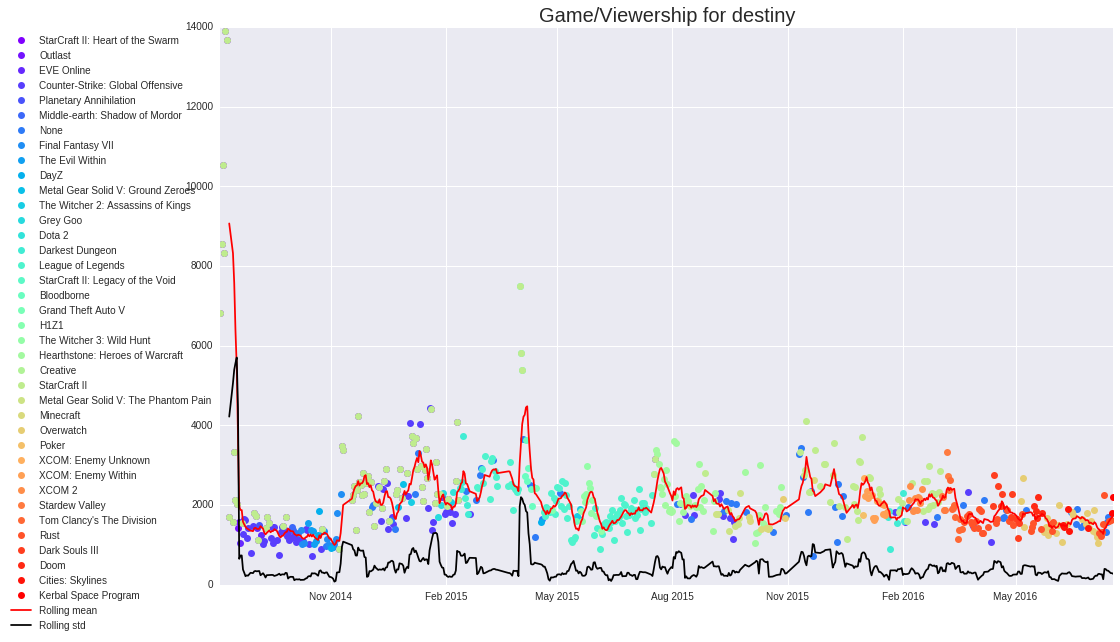

In [215]:
game_lpc(chan_filter(dfhv, 'destiny'),10)
# game_plotc(chan_filter(dfhv, 'destiny'))
plt.title('Game/Viewership for destiny', fontsize=20)

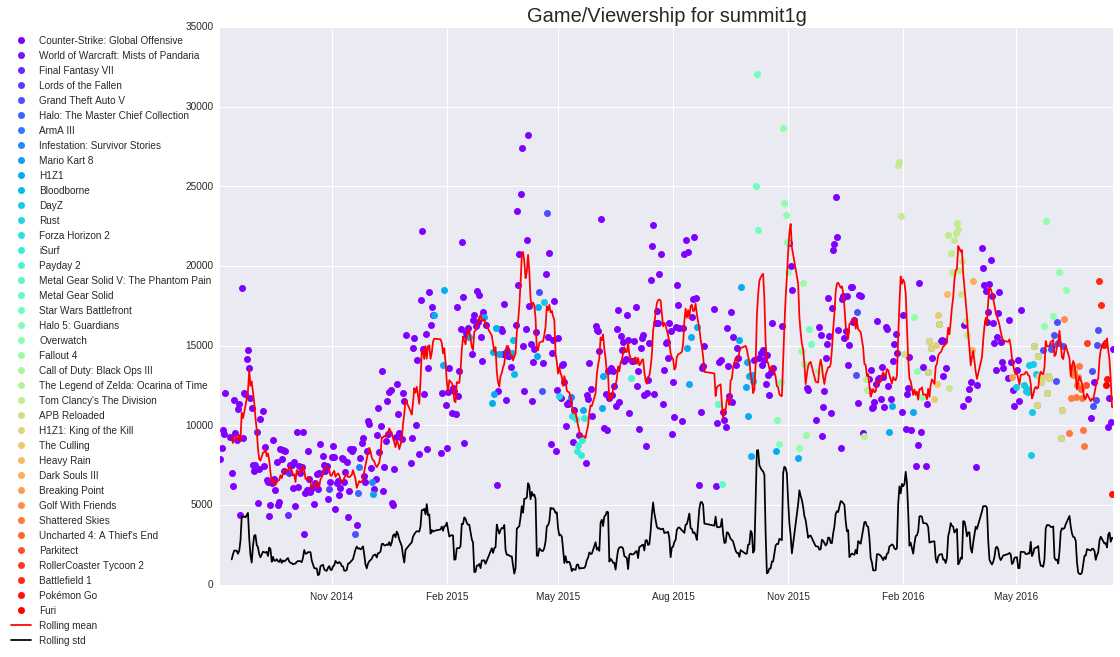

In [214]:
# game_plotc(chan_filter(dfhv, 'summit1g'))
game_lpc(chan_filter(dfhv, 'summit1g'), 10)
plt.title('Game/Viewership for summit1g', fontsize=20)

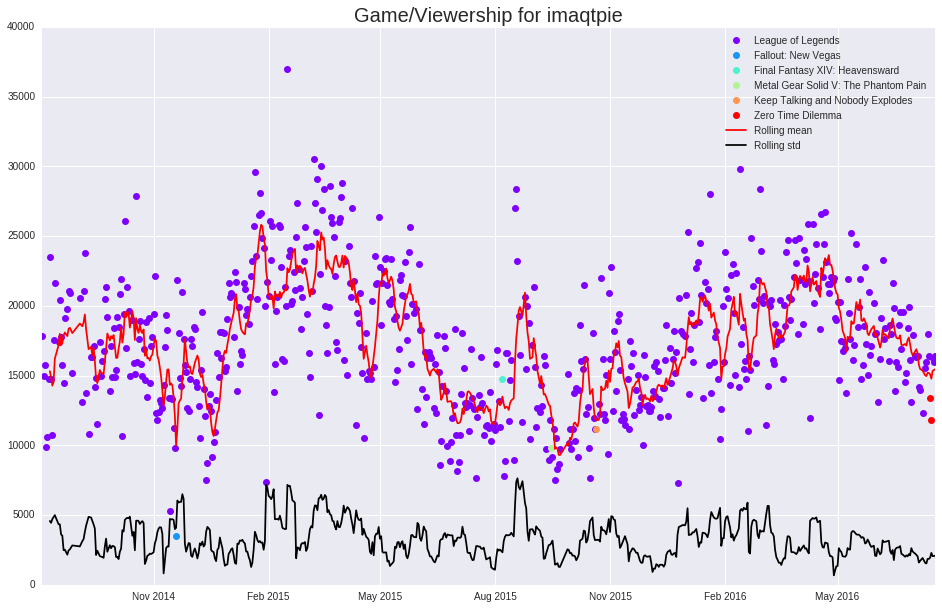

In [213]:
game_plotc(chan_filter(dfhv, 'imaqtpie'))
plt.title('Game/Viewership for imaqtpie', fontsize=20)

In [209]:
# plot_gameHW(dfng, 'Counter-Strike')

/home/derek/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


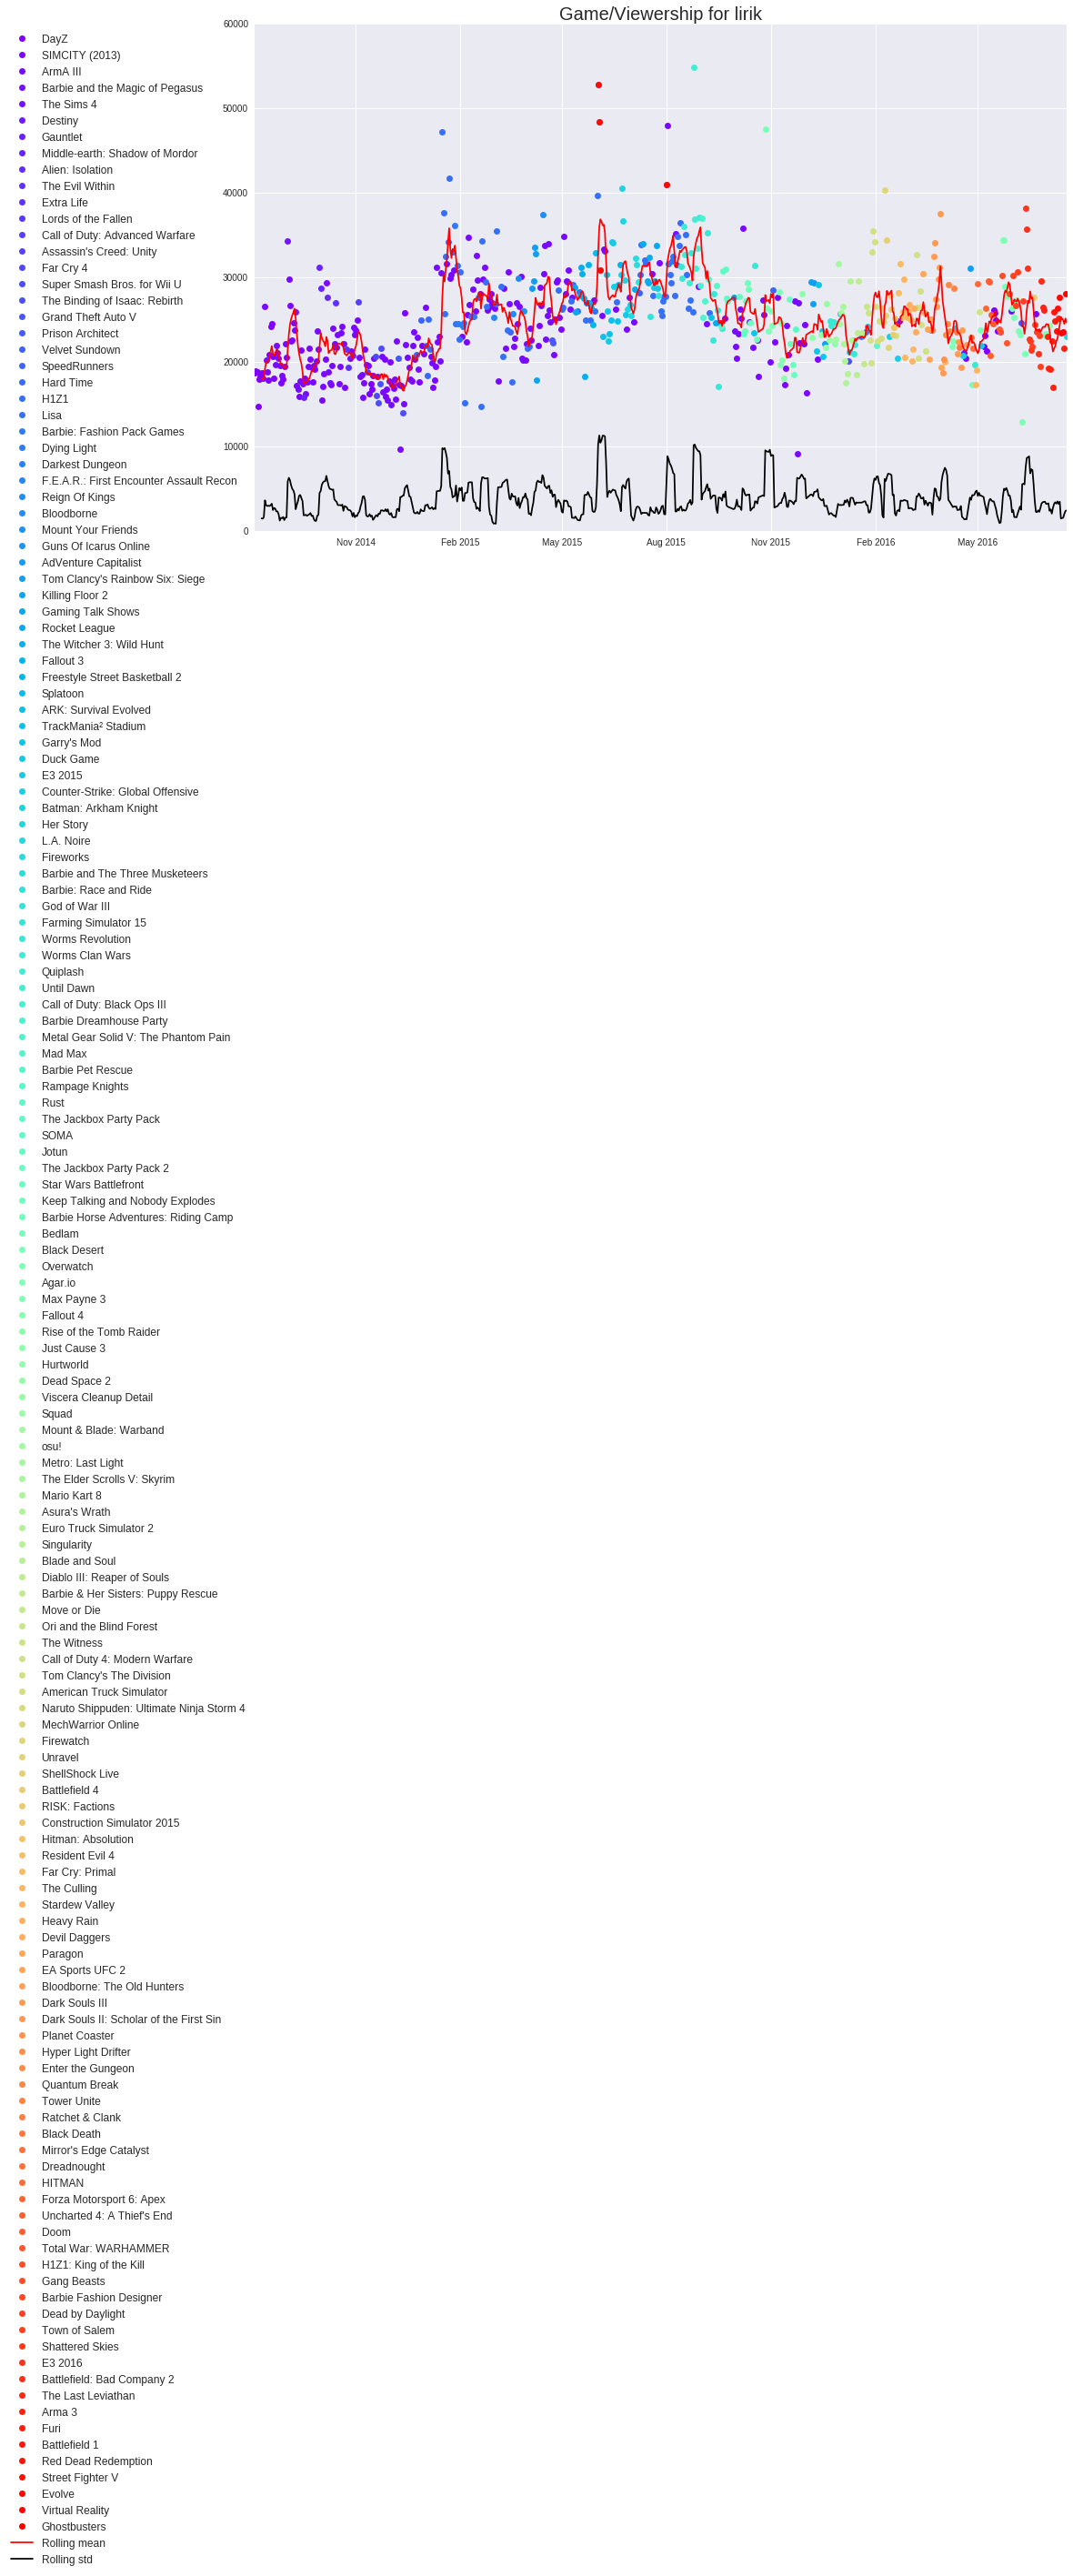

In [217]:
# game_plotc(chan_filter(dfng,'lirik'))
game_lpc(chan_filter(dfng,'lirik'))
plt.title('Game/Viewership for lirik', fontsize=20)


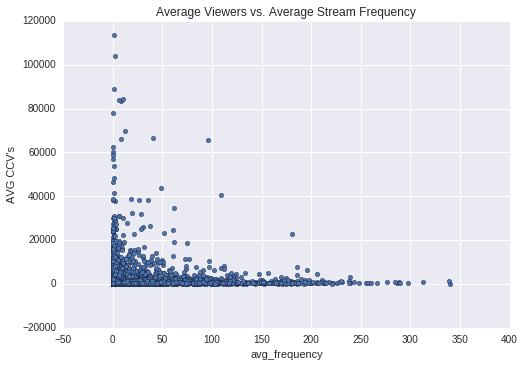

In [10]:
# dfn = df_filter(20,dff)
agdf = dff.groupby('Channel')[["AVG CCV's", 'avg_frequency']].mean()
agdf.plot(x='avg_frequency', y="AVG CCV's", kind='scatter')
plt.title('Average Viewers vs. Average Stream Frequency')

In [204]:
df1 = chan_filter(dfng, 'lirik')#.set_index('date', inplace=True)
df1.set_index('date', inplace=True)
def xybuild(df, lag=7, ahead=1):
    dft=df.copy()
    for i in np.arange(lag):
        dft['lagday{0}'.format(i+1)] = (dft["AVG CCV's"].shift((i+1))).fillna(0)
    y = dft["AVG CCV's"].shift(-ahead).fillna(0)
    dc = ['Channel','AirTime','Platform', 'tdelta','avg_frequency','Language', 'index','#', "AVG CCV's", 'weekofyear']
    X = dft.drop(dc, axis=1)
    
    return X, y

X, y = xybuild(df1)

In [211]:
X.columns

Index([             u'Main Game',          u'Hours Watched',
                    u'Max CCV's', u'Days_since_last_stream',
                    u'num_games',              u'dayofweek',
                      u'lagday1',                u'lagday2',
                      u'lagday3',                u'lagday4',
                      u'lagday5',                u'lagday6',
                      u'lagday7'],
      dtype='object')

In [208]:
rfr_params = {'n_estimators':300,
              'max_features':'sqrt',
              'n_jobs':-1}
Xd = pd.get_dummies(X, columns = ['Main Game', 'dayofweek'])
rfr = RandomForestRegressor(**rfr_params)
rfr.fit(Xd,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [209]:
# rfr.score(Xd,y)

0.91472370424396854

In [135]:
# df1.ix[pd.to_datetime('2014-10-23')+pd.DateOffset(-8):pd.to_datetime('2014-10-23')+pd.DateOffset(8)]

,index,#,Channel,Language,Main Game,Hours Watched,Max CCV's,AVG CCV's,AirTime,Platform,...,dayofweek,weekofyear,lagday1,lagday2,lagday3,lagday4,lagday5,lagday6,lagday7,lagday8
date,,,,,,,,,,,,,,,,,,,,,
2014-10-15,241203,4,lirik,english,ArmA III,172906,32574,21794,07:56,twitch,...,2,42,0,0,0,0,0,0,0,0
2014-10-16,192011,12,lirik,english,ArmA III,94345,26383,23295,04:03,twitch,...,3,42,0,0,0,0,0,0,0,0
2014-10-17,356410,11,lirik,english,ArmA III,104218,21650,17466,05:58,twitch,...,4,42,0,0,0,0,0,0,0,0
2014-10-18,412208,9,lirik,english,ArmA III,149128,24764,19493,07:39,twitch,...,5,42,0,0,0,0,0,0,0,0
2014-10-19,63609,10,lirik,english,ArmA III,146414,31769,23426,06:15,twitch,...,6,42,0,0,0,0,0,0,0,0
2014-10-20,142806,7,lirik,english,ArmA III,158718,29864,24170,06:34,twitch,...,0,43,0,0,0,0,0,0,0,0
2014-10-21,97808,9,lirik,english,ArmA III,126613,29877,22212,05:42,twitch,...,1,43,0,0,0,0,0,0,0,0
2014-10-22,262809,10,lirik,english,ArmA III,97364,22963,17031,05:43,twitch,...,2,43,0,0,0,0,0,0,0,0
2014-10-24,139809,10,lirik,english,Extra Life,103211,31066,21577,04:47,twitch,...,4,43,0,0,0,0,0,0,0,0
